<p style="text-align: center;font-size: 24px;"><strong>UC Berkeley ML and AI Capstone Project</strong></p>
<p style="text-align: center;font-size: 20px;"><strong>Telecommunication Customer Churn Analysis and Prediction</strong></p>
<p style="text-align: right;font-size: 14px;">by Bowang Xiao, June 2025</p>
 

## OVERVIEW

This is to analyze and predict wheater the customer will stay in the program. Customers who left within the last month – the column is called Churn. 
Two objectives.
1) analyze which factor affect the churn score the most.
2) build a model to predict the churn score so that the company can do something to keep the customer.

## The data

https://www.kaggle.com/datasets/blastchar/telco-customer-churn?resource=download 

Context

"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]
Content
Each row represents a customer, each column contains customer’s attributes described on the column Metadata.
The data set includes information about:
- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import confusion_matrix, roc_curve, auc

from scipy.stats import zscore

from sklearn.datasets import load_digits

from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score


from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import time
from joblib import parallel_backend

In [2]:
## loading the data
churn = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
digits, labels = load_digits(return_X_y=True)

In [3]:
churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
churn.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


## Data Preparation -- 1. Cleanup
After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling. Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with sklearn.

In [6]:
churn['TotalCharges'] = churn['TotalCharges'].replace(' ', np.nan).astype('float')
## removes all rows from the churn DataFrame that contain any missing (NaN) values. 
churn = churn.dropna()

## drop the customerID, which is not related to the churn score.
churn = churn.drop(columns='customerID')

churn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 
 17  

## Data Preparation -- 2. Remove Outliers


In [7]:
## Outliers analysis to identify anomalies in the dataset.
## After examin the sample data, we can see there are 3 numerical features.
churn[['SeniorCitizen','tenure', 'MonthlyCharges', 'TotalCharges']].value_counts()

SeniorCitizen  tenure  MonthlyCharges  TotalCharges
0              1       20.20           20.20           11
                       19.75           19.75            9
                       19.90           19.90            8
                       19.65           19.65            8
                       20.05           20.05            7
                                                       ..
               22      94.65           2104.55          1
                       93.20           2157.30          1
                       90.00           1993.80          1
                       89.40           2001.50          1
1              72      117.35          8436.25          1
Name: count, Length: 6814, dtype: int64

In [8]:
churn[['tenure', 'MonthlyCharges', 'TotalCharges']].describe()
from scipy.stats import zscore

z_scores = churn[['tenure', 'MonthlyCharges', 'TotalCharges']].apply(zscore)
outliers = (abs(z_scores) > 3)

outlier_summary = outliers.sum()
print("Number of outliers by feature:\n", outlier_summary)

Number of outliers by feature:
 tenure            0
MonthlyCharges    0
TotalCharges      0
dtype: int64


In [9]:
def detect_iqr_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return ((series < (Q1 - 1.5 * IQR)) | (series > (Q3 + 1.5 * IQR)))

outliers_iqr = churn[['tenure', 'MonthlyCharges', 'TotalCharges']].apply(detect_iqr_outliers)
print("Outliers detected (IQR method):")
print(outliers_iqr.sum())

Outliers detected (IQR method):
tenure            0
MonthlyCharges    0
TotalCharges      0
dtype: int64


In [10]:
## split the data to train set and test set. set y=churn['Churn'] , Default test_size = 0.25, random_state = 42 or 442, both are fine.
X_train, X_test, y_train, y_test = train_test_split(churn.drop(['Churn'], axis = 1), churn['Churn'], random_state = 442,
                                                   stratify = churn['Churn'])

## Data Preparation -- 3. transformation
- incorporate many of the categorical features
- Use the make_column_transformer function on the the columns selected by selector. To these columns, apply the OneHotEncoder with drop = first. To the remainder columns, apply StandardScaler()
- Feature Extractor

In [11]:
selector = make_column_selector(dtype_include=object)
transformer = make_column_transformer((OneHotEncoder(drop = 'first'), selector),
                                     remainder = StandardScaler())

## select the logistic Regression as a base model with a penalty to avoid overfitting.
extractor = SelectFromModel(LogisticRegression(penalty='l1', solver = 'liblinear' ,random_state = 42))


## Data Understanding and visualization

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

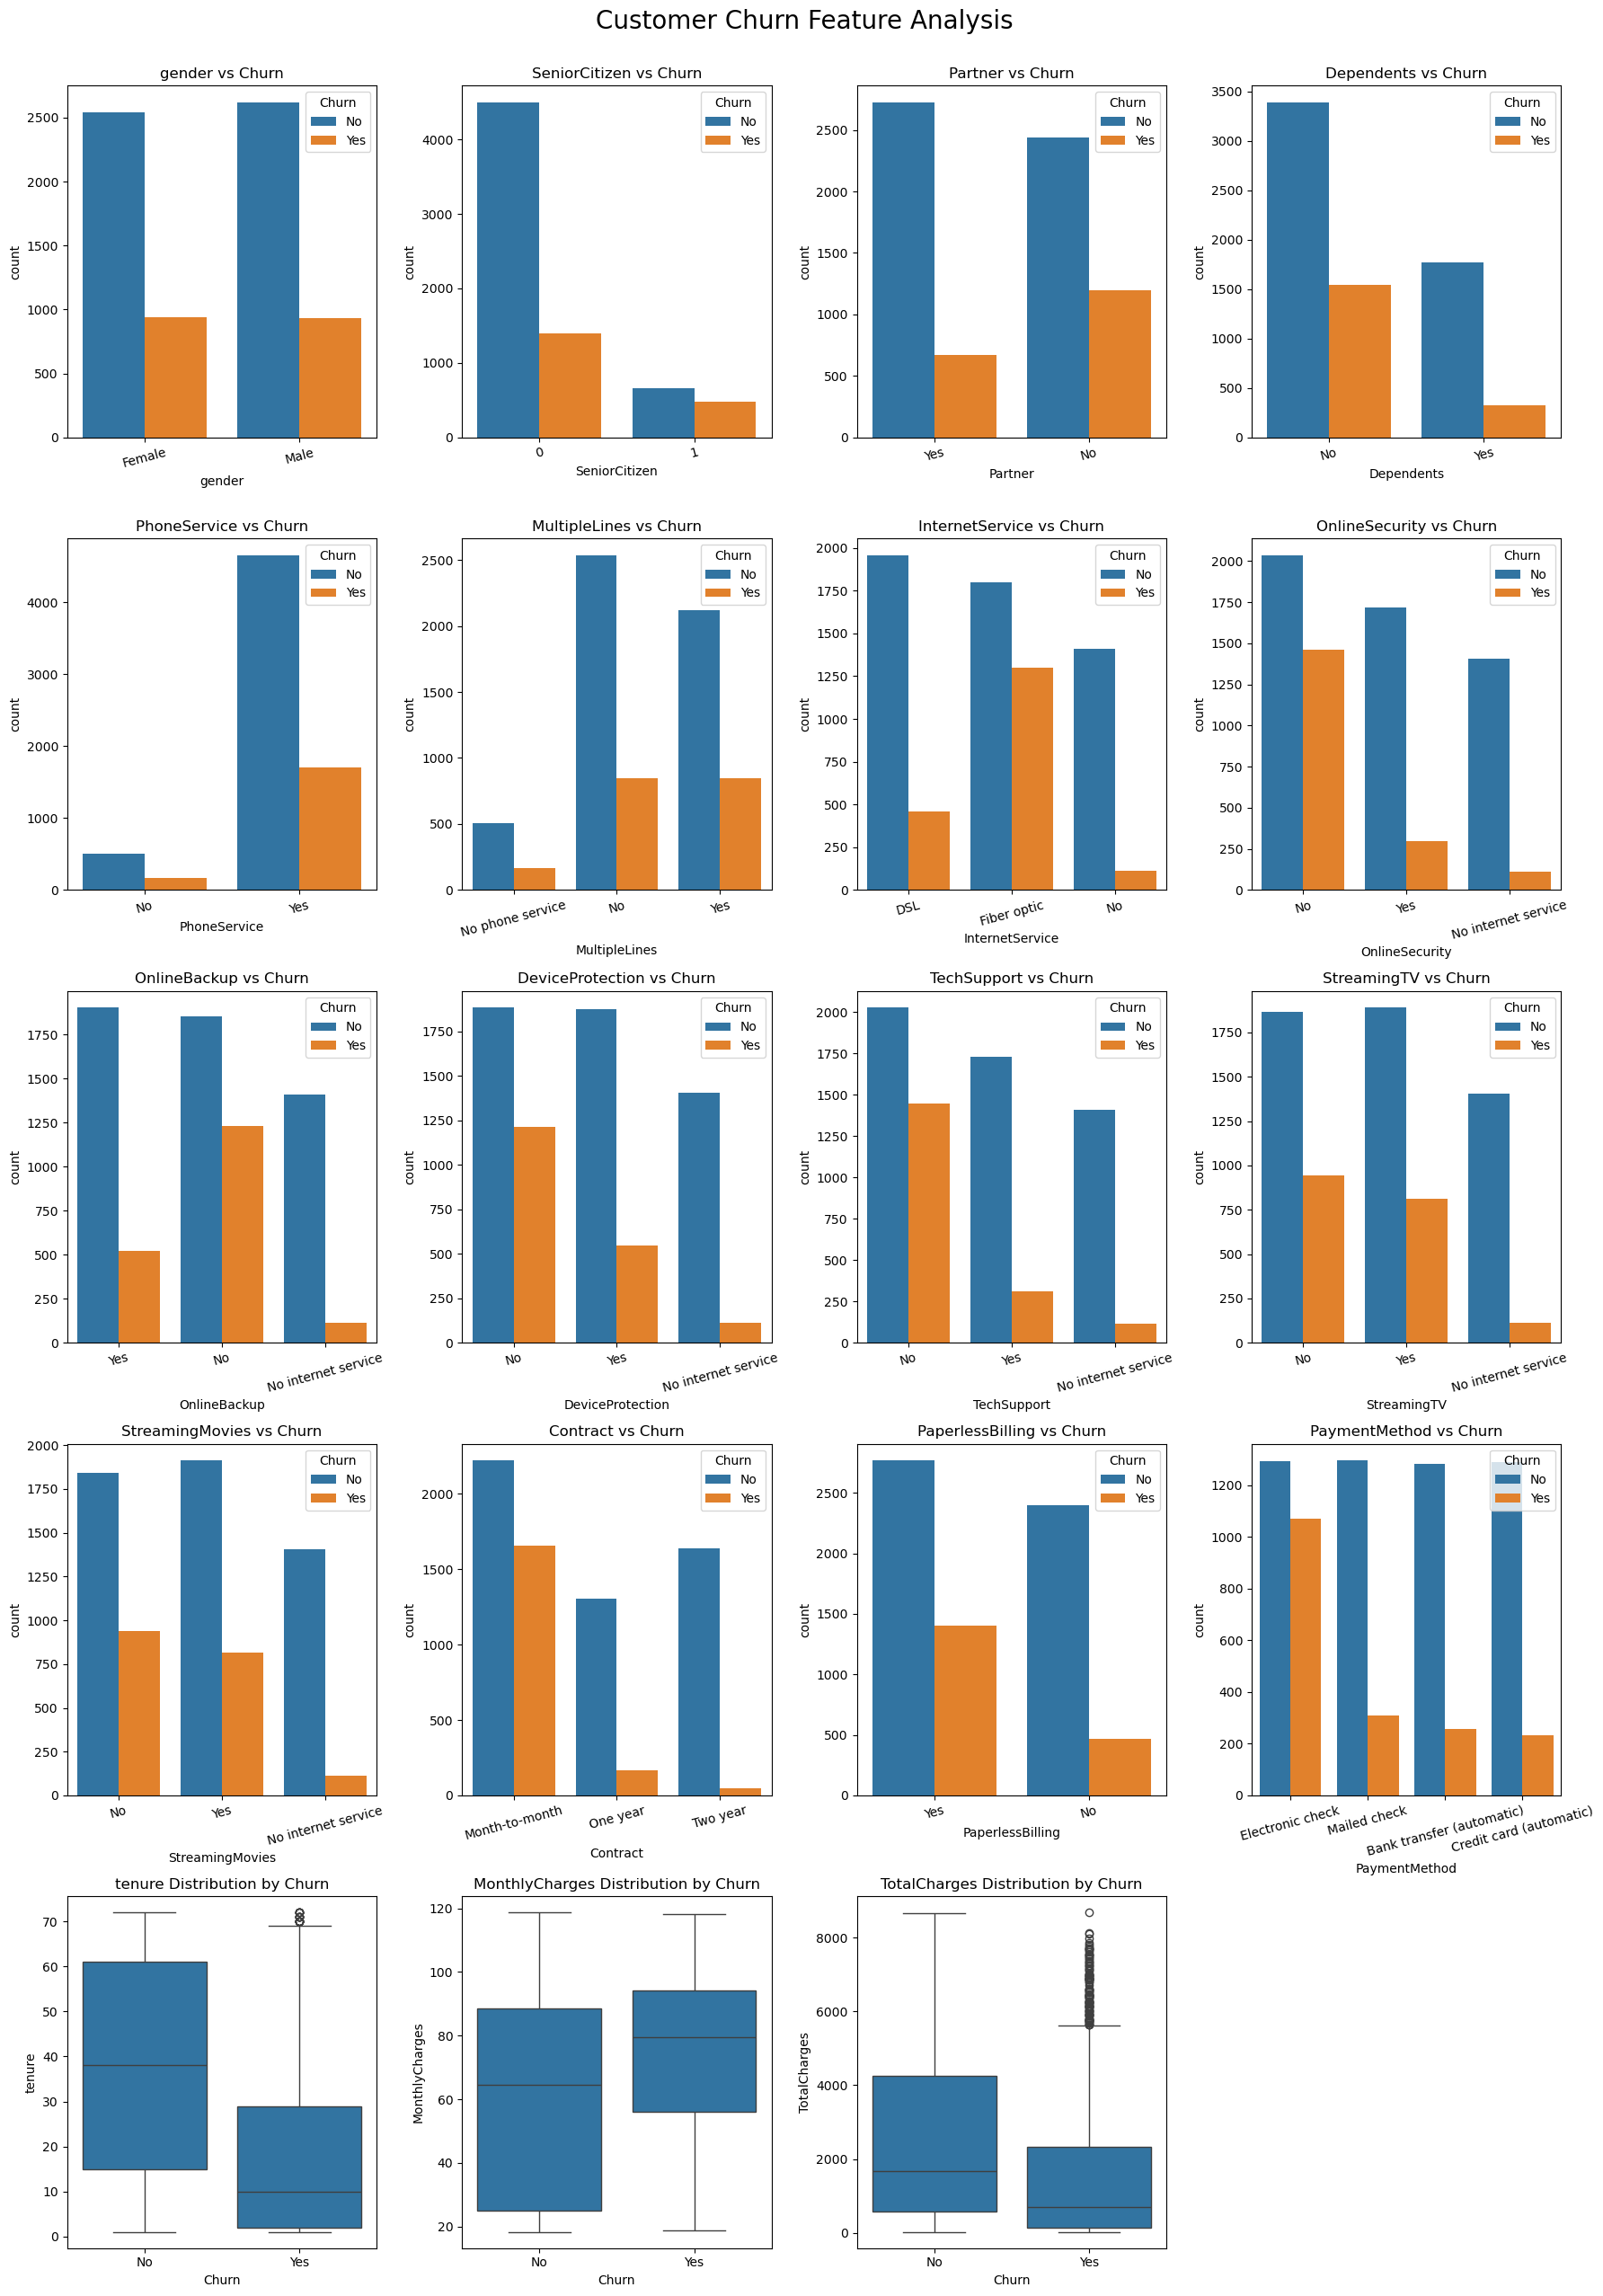

In [12]:
# Identify features
categorical_features = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]

numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Set up subplots: adjust rows and columns to fit all features
total_features = len(categorical_features) + len(numerical_features)
ncols = 4
nrows = (total_features + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 5 * nrows))
axes = axes.flatten()

# Plot categorical features
for i, feature in enumerate(categorical_features):
    sns.countplot(data=churn, x=feature, hue='Churn', ax=axes[i])
    axes[i].set_title(f'{feature} vs Churn')
    axes[i].tick_params(axis='x', rotation=15)
    axes[i].legend(title='Churn')

# Plot numerical features
for j, feature in enumerate(numerical_features):
    sns.boxplot(data=churn, x='Churn', y=feature, ax=axes[len(categorical_features) + j])
    axes[len(categorical_features) + j].set_title(f'{feature} Distribution by Churn')

# Hide any unused subplots
for k in range(total_features, len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.suptitle("Customer Churn Feature Analysis", fontsize=20, y=1.02)
plt.show()

Text(0, 0.5, 'Number of Customers')

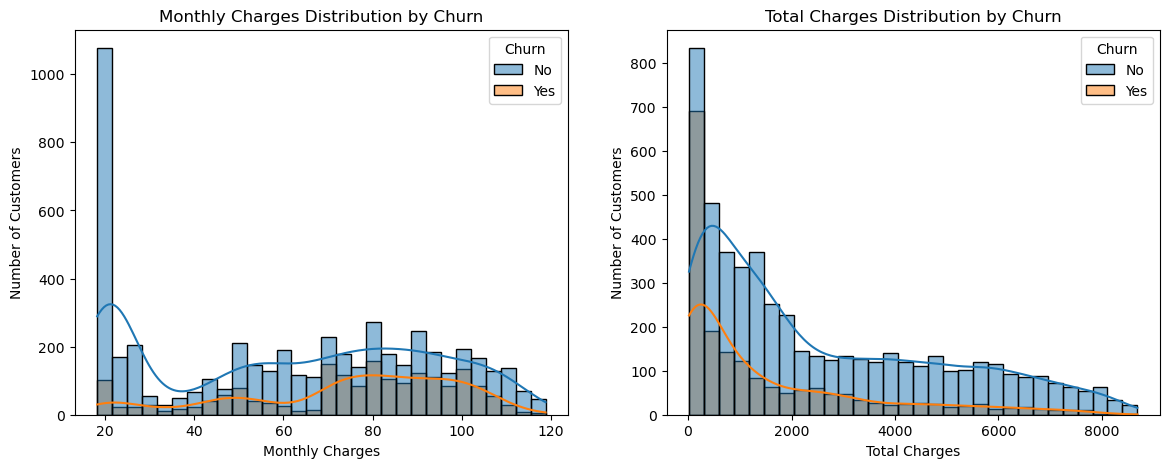

In [13]:
## Plot Churn VS. MonthlyCharges

# Set up the side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MonthlyCharges histogram
sns.histplot(data=churn, x='MonthlyCharges', hue='Churn', kde=True, bins=30, ax=axes[0])
axes[0].set_title("Monthly Charges Distribution by Churn")
axes[0].set_xlabel("Monthly Charges")
axes[0].set_ylabel("Number of Customers")

# TotalCharges histogram
sns.histplot(data=churn, x='TotalCharges', hue='Churn', kde=True, bins=30, ax=axes[1])
axes[1].set_title("Total Charges Distribution by Churn")
axes[1].set_xlabel("Total Charges")
axes[1].set_ylabel("Number of Customers")

## Intuitive impression from the above plots
#### these features affect the churn score much.
- SeniorCitizen
- Dependents
- InternetService
- Contract
- tenure
- MonthlyCharges

#### these features do not affect the churn score much.
- gender
- Partner
- StreamingMovies
- StreamingTV
- MultipleLines
- MultipleLines
- PaymentMethod
- DeviceProtection
#### these features affect the churn score somehow.
- PhoneService
- PaperlessBilling
- PaymentMethod


## Correlation Analysis


In [14]:
churn_encoded = pd.get_dummies(churn, drop_first=True)
churn_encoded.info()
churn_encoded.sample(5)

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          7032 non-null   int64  
 1   tenure                                 7032 non-null   int64  
 2   MonthlyCharges                         7032 non-null   float64
 3   TotalCharges                           7032 non-null   float64
 4   gender_Male                            7032 non-null   bool   
 5   Partner_Yes                            7032 non-null   bool   
 6   Dependents_Yes                         7032 non-null   bool   
 7   PhoneService_Yes                       7032 non-null   bool   
 8   MultipleLines_No phone service         7032 non-null   bool   
 9   MultipleLines_Yes                      7032 non-null   bool   
 10  InternetService_Fiber optic            7032 non-null   bool   
 11  InternetS

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
4719,0,36,84.90,3067.20,True,False,False,True,False,True,...,False,False,True,False,False,True,False,True,False,True
4587,0,26,85.90,2196.45,False,True,False,True,False,False,...,False,False,True,False,False,False,True,False,False,False
785,1,46,110.00,4874.80,False,False,False,True,False,True,...,True,False,True,True,False,True,False,True,False,True
2362,0,49,39.20,1838.15,True,True,True,False,True,False,...,False,False,True,False,False,True,False,True,False,False
5260,0,33,90.65,2989.60,False,False,False,True,False,True,...,False,False,True,False,False,True,False,True,False,False


In [15]:
# Calculate correlation matrix
correlation_matrix = churn_encoded.sample(1000).corr()

# Display the correlation of each feature with price
churn_correlation = correlation_matrix['Churn_Yes'].sort_values(ascending=False)
print(churn_correlation)

Churn_Yes                                1.000000
InternetService_Fiber optic              0.343984
PaymentMethod_Electronic check           0.337044
MonthlyCharges                           0.224997
PaperlessBilling_Yes                     0.171083
SeniorCitizen                            0.156868
StreamingTV_Yes                          0.113366
MultipleLines_Yes                        0.073726
StreamingMovies_Yes                      0.065683
MultipleLines_No phone service           0.008346
PhoneService_Yes                        -0.008346
gender_Male                             -0.018216
DeviceProtection_Yes                    -0.042602
PaymentMethod_Mailed check              -0.078737
Partner_Yes                             -0.094311
TechSupport_Yes                         -0.127457
Dependents_Yes                          -0.133440
OnlineBackup_Yes                        -0.134132
OnlineSecurity_Yes                      -0.146374
PaymentMethod_Credit card (automatic)   -0.150071


In [16]:
## from the correlation matirx, we can see most of the features impact the churn score 
## The below features are not affecting the churn score much.
# StreamingMovies_Yes                      0.020348
# StreamingTV_Yes                          0.006431
# PhoneService_Yes                         0.004655
# MultipleLines_No phone service          -0.004655
# MultipleLines_Yes                       -0.013502
# gender_Male                             -0.023184
# PaymentMethod_Mailed check              -0.073559
# DeviceProtection_Yes                    -0.077618

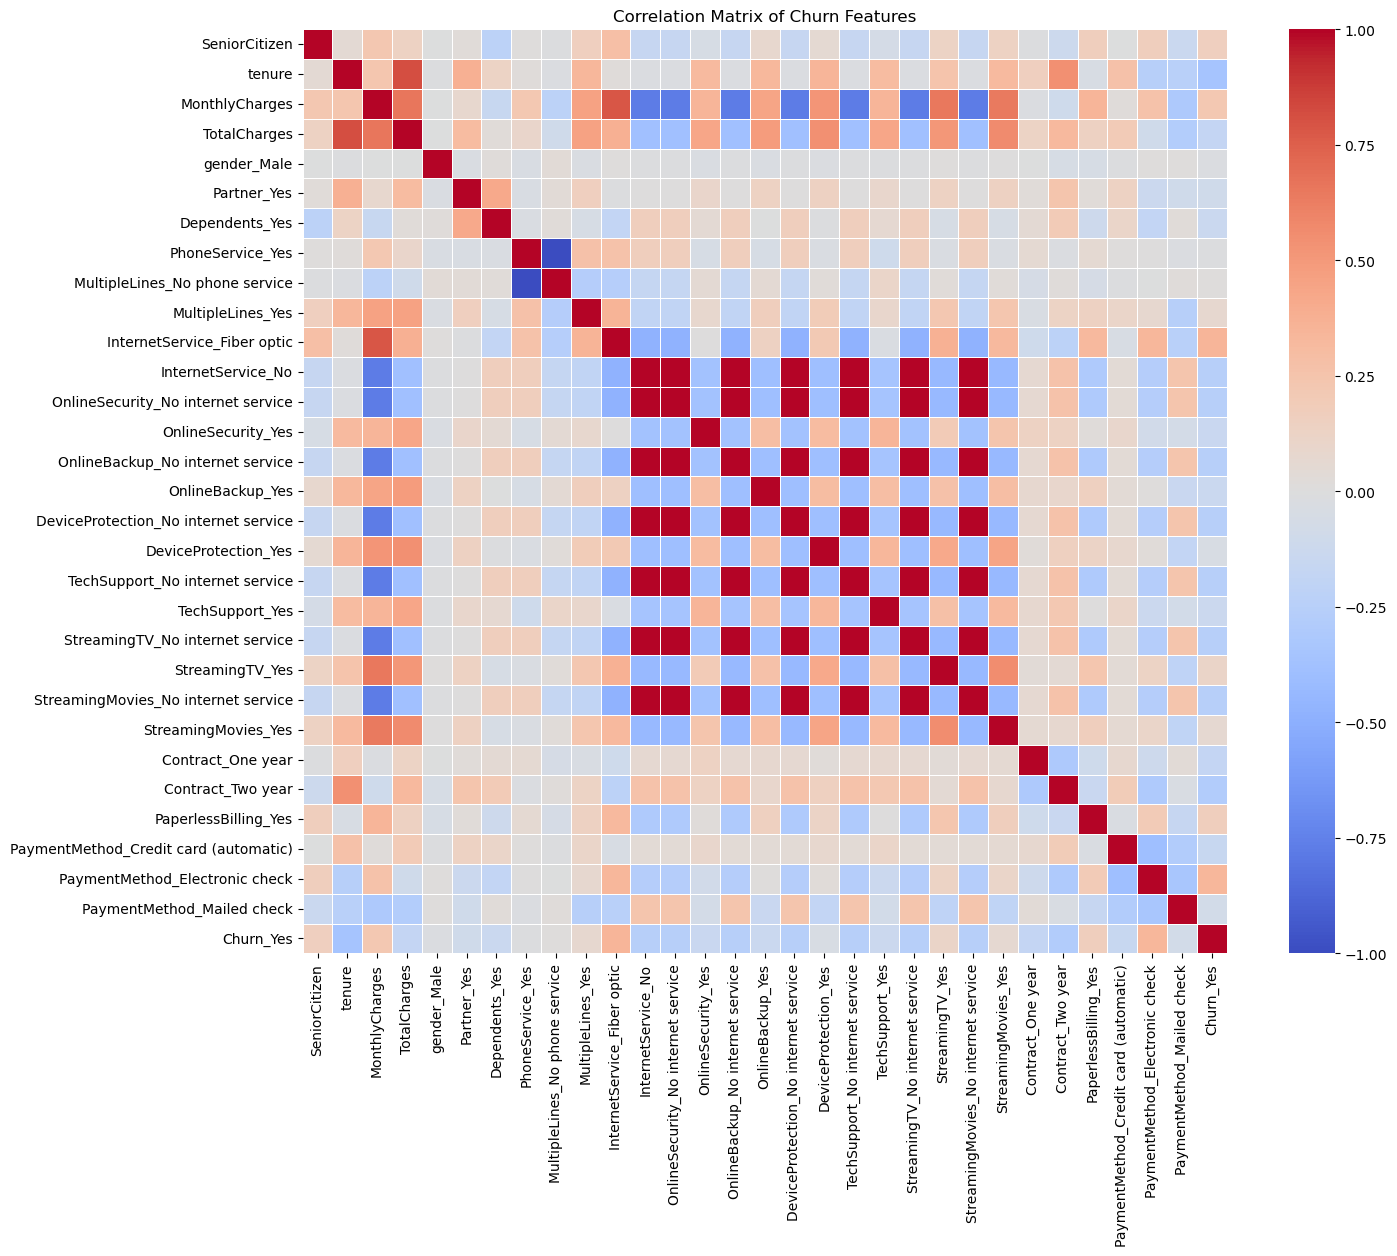

In [17]:
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=False, fmt='.2f', square=True, linewidths=0.5)
plt.title("Correlation Matrix of Churn Features")
plt.show()

## Data analysis summary
While the intuitive analysis on the plots can give us some rough ideas of each feature's importance, the correlation analysis can give us numerical evaluation of each feature influence, either positive correlation (toward churn score 1), or negative correlation (toward churn score 0).

- In general, long tenure customers, 2 year contracts will stay longer with the program. 
- The customers without internet will stay longer, and on the opposite, the customers with fast fiber internet more likely to leave.
- when the monthly charges is below **\$60** , churn score is low, and then increases from **\$60** to **\$100**. and then decrease after \$100. It means the low income and high income will more likely stay.
- autopay will help keep the customers, and electronic check lead to high churn score. Surprisingly, the very traditional payment method, mailed check, lead to low churn score.
- paperbilling lead to higher churn score. The company should encourage electronic billing to keep the customers and also save mailing cost.

#### 📈 Features Associated with Higher Churn Risk

| Feature                            | Churn Impact Score |
|------------------------------------|---------------------|
| InternetService_Fiber optic        | +0.275044           |
| PaymentMethod_Electronic check     | +0.267562           |
| MonthlyCharges                     | +0.178816           |
| PaperlessBilling_Yes               | +0.175606           |
| SeniorCitizen                      | +0.169751           |

#### 📉 Features Associated with Lower Churn Risk (Customer Retention)

| Feature                              | Churn Impact Score |
|--------------------------------------|---------------------|
| Dependents_Yes                       | −0.183059           |
| TotalCharges                         | −0.205597           |
| StreamingTV_No internet service      | −0.212728           |
| StreamingMovies_No internet service  | −0.212728           |
| DeviceProtection_No internet service | −0.212728           |
| OnlineBackup_No internet service     | −0.212728           |
| OnlineSecurity_No internet service   | −0.212728           |
| InternetService_No                   | −0.212728           |
| TechSupport_No internet service      | −0.212728           |
| Contract_Two year                    | −0.282444           |
| tenure                               | −0.355997           |


## Modeling with a base model
With the final dataset in hand, lets build a model as the baseline. 

In [18]:
## build a pipeline for the data transformation and training.
LogisticRegression_pipe = Pipeline([('transformer', transformer),
                    ('selector', extractor),
                    ('lgr', LogisticRegression(random_state=42, max_iter = 1000))])



In [19]:
## print the pipeline structure

print(LogisticRegression_pipe)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000211AF9F9B80>)])),
                ('selector',
                 SelectFromModel(estimator=LogisticRegression(penalty='l1',
                                                              random_state=42,
                                                              solver='liblinear'))),
                ('lgr', LogisticRegression(max_iter=1000, random_state=42))])


In [20]:
## plot the pipeline structure
from sklearn import set_config
set_config(display='diagram')

LogisticRegression_pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000211AF9F9B80>)])),
                ('selector',
                 SelectFromModel(estimator=LogisticRegression(penalty='l1',
                                                              random_state=42,
                                                              solver='liblinear'))),
                ('lgr', LogisticRegression(max_iter=1000, random_state=42))])

## The criteria to evaluate the model, confusion matrix

Train Accuracy: 0.8015
Test Accuracy:  0.8185


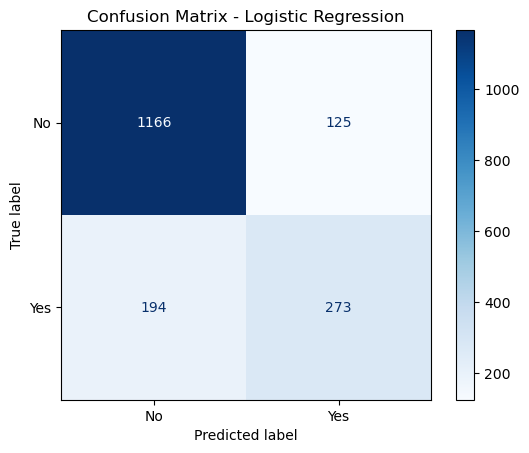

In [21]:
LogisticRegression_pipe.fit(X_train, y_train)

# Accuracy scores
train_acc = LogisticRegression_pipe.score(X_train, y_train)
test_acc = LogisticRegression_pipe.score(X_test, y_test)

# Print accuracies
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")

# Predict on test set
y_pred = LogisticRegression_pipe.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LogisticRegression_pipe.classes_)

# Plot
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


In [22]:
# Calculate recall for the positive class (e.g., 'Churn' = 'Yes')
recall = recall_score(y_test, y_pred, pos_label='Yes')  
print(f"Recall: {recall:.4f}")

Recall: 0.5846


## Initial Report and Exploratory Data Analysis (EDA)
- The features of the churn data set are analyzed through the plots and correlation analysis. The tenure, contract length, internet service and monthly charges play important roles in the churn score.
- The data is cleaned and transformed for ML models. A Logistic Regression model is used for the intial training and prediction as the baseline. Its accuracy is about 80%. 
- More models will be tuned with grid search and compared for the final report. We expect to develop a model with 95% and higher accuracy so that the telecommunication company can do some special promotions to keep the customers with high churn scores.


### Different modeling, tuning and evaluation
- Will try different models with tuned parameters, and then evaluate the prediction.
The goals is to choose the best accurate model.
- Will also discuss the evaluation criteria, accuracy or call back?
  For binary classification, it looks like this:

|                      | **Predicted Positive** | **Predicted Negative** |
|----------------------|------------------------|------------------------|
| **Actual Positive**  | True Positive (TP)     | False Negative (FN)   |
| **Actual Negative**  | False Positive (FP)    | True Negative (TN)    |

Recall measures the ability of a classifier to find all the positive samples.
**Formula:**

$ \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}} $
 


Recall (also known as sensitivity or true positive rate) measures how many actual churners your model correctly identifies.
Missing a churner (a false negative) means you don't take action to retain them — a lost opportunity.


## Compare differnet models to optimize your model to maximize recall 

### Model Hyperparameter Table

| Model            | Hyperparameters |
|------------------|-----------------|
| `logisticregression` | `C`: [0.01, 0.1, 1, 10] |
| `knn`            | `n_neighbors`: [3, 5, 7], `weights`: ['uniform', 'distance'] |
| `svc`            | `C`: [0.1, 1, 10], `kernel`: ['linear', 'rbf'], `gamma`: ['scale', 'auto'] |
| `decisiontree`   | `max_depth`: [5, 10, 15], `min_samples_split`: [2, 5] |
| `RandomForest`   | `n_estimators`: [100, 200], `max_depth`: [None, 10, 20] |



In [23]:
## split the data to train set and test set. set y=churn['Churn']
# X_train, X_test, y_train, y_test = train_test_split(churn.drop(['Churn'], axis = 1), churn['Churn'], random_state = 42,
#                                                    stratify = churn['Churn'])
# selector = make_column_selector(dtype_include=object)
# transformer = make_column_transformer((OneHotEncoder(drop = 'first'), selector),
#                                      remainder = StandardScaler())
# extractor = SelectFromModel(LogisticRegression(penalty='l1', solver = 'liblinear' ,random_state = 42))


In [24]:
## to be addded. try differnet models to optimize your model to maximize recall 


# Define models and their hyperparameters
models = {
    'logisticregression': (LogisticRegression(max_iter=1000), {'logisticregression__C': [0.01, 0.1, 1, 10]}),
    'knn': (KNeighborsClassifier(), {'knn__n_neighbors': [3, 5, 7], 'knn__weights': ['uniform', 'distance']}),
    'svc': (SVC(probability=True), {'svc__C': [0.1, 1, 10], 'svc__kernel': ['linear', 'rbf'], 'svc__gamma': ['scale', 'auto']}),
    'decisiontree': (DecisionTreeClassifier(), {'decisiontree__max_depth': [5, 10, 15],'decisiontree__min_samples_split': [2, 5]}),
    'RandomForest':(RandomForestClassifier(),{'RandomForest__n_estimators': [100, 200],'RandomForest__max_depth': [None, 10, 20]})
}

results = []
best_models = {}

# Train and evaluate each model
for name, (model, params) in models.items():
    # Create a pipeline with StandardScaler and the model
    pipeline = Pipeline([
        ('transformer', transformer),
        ('selector', extractor),
        (name, model)
    ])


    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1)
    
    # Fit the model and time it
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    fit_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])
    
    # Get the best estimator and save it to best_models
    best_model = grid_search.best_estimator_
    best_models[name] = best_model  # Save best model here!
    
    # Evaluate on training and test sets
    train_score = best_model.score(X_train, y_train)
    test_score = best_model.score(X_test, y_test)

    # Predict on test set and calculate recall
    y_pred = best_model.predict(X_test)
    test_recall = recall_score(y_test, y_pred, pos_label='Yes')
    ##print(y_pred)
    
    # Change the classification threshold (default is 0.5). Lower it to capture more churners (increase recall).
    y_proba = best_model.predict_proba(X_test)[:, 1]
    y_pred_proba3 = np.where((y_proba > 0.3), 'Yes', 'No')     
    # Calculate recall score with lower threshold
    test_recall_lowerP3 = recall_score(y_test, y_pred_proba3, pos_label='Yes')
    test_score_lowerP3 = best_model.score(X_test, y_pred_proba3)

    y_pred_proba4 = np.where((y_proba > 0.4), 'Yes', 'No')     
    # Calculate recall score with lower threshold
    test_recall_lowerP4 = recall_score(y_test, y_pred_proba4, pos_label='Yes')
    test_score_lowerP4 = best_model.score(X_test, y_pred_proba4)
    
    # Append the results
    results.append([name, train_score, test_score, test_score_lowerP3, test_score_lowerP4, test_recall, test_recall_lowerP3, test_recall_lowerP4, fit_time])

    # Print best parameters and recall
    print(f"\nModel: {name}")
    print("Best Parameters:", grid_search.best_params_)
    print("Recall Score on Test Set:", test_recall)
    print("Recall Score on Test Set (lower threshold, 30%):", test_recall_lowerP3)
    print("Recall Score on Test Set (lower threshold, 40%):", test_recall_lowerP4)


# Create the results DataFrame
results_df = pd.DataFrame(results, columns=['model', 'train score', 'test score', 'test score thr30%', 'test score thr40%', 'test recall','test recall thr30%','test recall thr40%','average fit time'])
results_df.set_index('model', inplace=True)

# Display the DataFrame
# Set display option to show all columns in one line (no wrapping)
pd.set_option('display.width', None)          # Remove width limit
pd.set_option('display.width', 1000)                 # Set width wide enough
pd.set_option('display.max_columns', None)    # Show all columns
print(results_df)



Model: logisticregression
Best Parameters: {'logisticregression__C': 1}
Recall Score on Test Set: 0.5845824411134903
Recall Score on Test Set (lower threshold, 30%): 0.8072805139186295
Recall Score on Test Set (lower threshold, 40%): 0.6895074946466809

Model: knn
Best Parameters: {'knn__n_neighbors': 7, 'knn__weights': 'uniform'}
Recall Score on Test Set: 0.550321199143469
Recall Score on Test Set (lower threshold, 30%): 0.7301927194860813
Recall Score on Test Set (lower threshold, 40%): 0.7301927194860813

Model: svc
Best Parameters: {'svc__C': 10, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}
Recall Score on Test Set: 0.49036402569593146
Recall Score on Test Set (lower threshold, 30%): 0.6059957173447538
Recall Score on Test Set (lower threshold, 40%): 0.5117773019271948

Model: decisiontree
Best Parameters: {'decisiontree__max_depth': 5, 'decisiontree__min_samples_split': 5}
Recall Score on Test Set: 0.44539614561027835
Recall Score on Test Set (lower threshold, 30%): 0.755888650963

In [25]:
# Display the DataFrame

results_df = pd.DataFrame(results, columns=['model', 'train score', 'test score', 'test score thr30%', 'test score thr40%', 'test recall','test recall thr30%','test recall thr40%','average fit time'])
results_df.set_index('model', inplace=True)
# Set display option to show all columns in one line (no wrapping)

pd.set_option('display.max_columns', None)           # Show all columns
pd.set_option('display.width', 1000)                 # Set width wide enough
pd.set_option('display.expand_frame_repr', False)    # Prevent line wrapping

print(results_df)

                    train score  test score  test score thr30%  test score thr40%  test recall  test recall thr30%  test recall thr40%  average fit time
model                                                                                                                                                   
logisticregression     0.801479    0.818544           0.840728           0.922639     0.584582            0.807281            0.689507          0.676240
knn                    0.820440    0.779295           0.883959           0.883959     0.550321            0.730193            0.730193          0.308591
svc                    0.810770    0.804892           0.936860           0.986917     0.490364            0.605996            0.511777          4.612029
decisiontree           0.797876    0.795222           0.823094           0.846416     0.445396            0.755889            0.719486          0.368158
RandomForest           0.871824    0.820250           0.835040           0.918658 

In [26]:
#                     train score  test score  test_recall  average fit time
#                     train score  test score  test score thr30%  tes score thr40%  test recall  test recall thr30%  test recall thr40%  average fit time
# model                                                                                                                                                  
# logisticregression     0.801479    0.818544           0.840728          0.922639     0.584582            0.807281            0.689507          0.629746
# knn                    0.820440    0.779295           0.883959          0.883959     0.550321            0.730193            0.730193          0.304267
# svc                    0.810770    0.804892           0.935722          0.984073     0.490364            0.610278            0.520343          4.575740
# decisiontree           0.798066    0.794653           0.824801          0.846416     0.445396            0.755889            0.719486          0.386934
# RandomForest           0.872962    0.820250           0.828783          0.922071     0.552463            0.790150            0.683084          1.302739



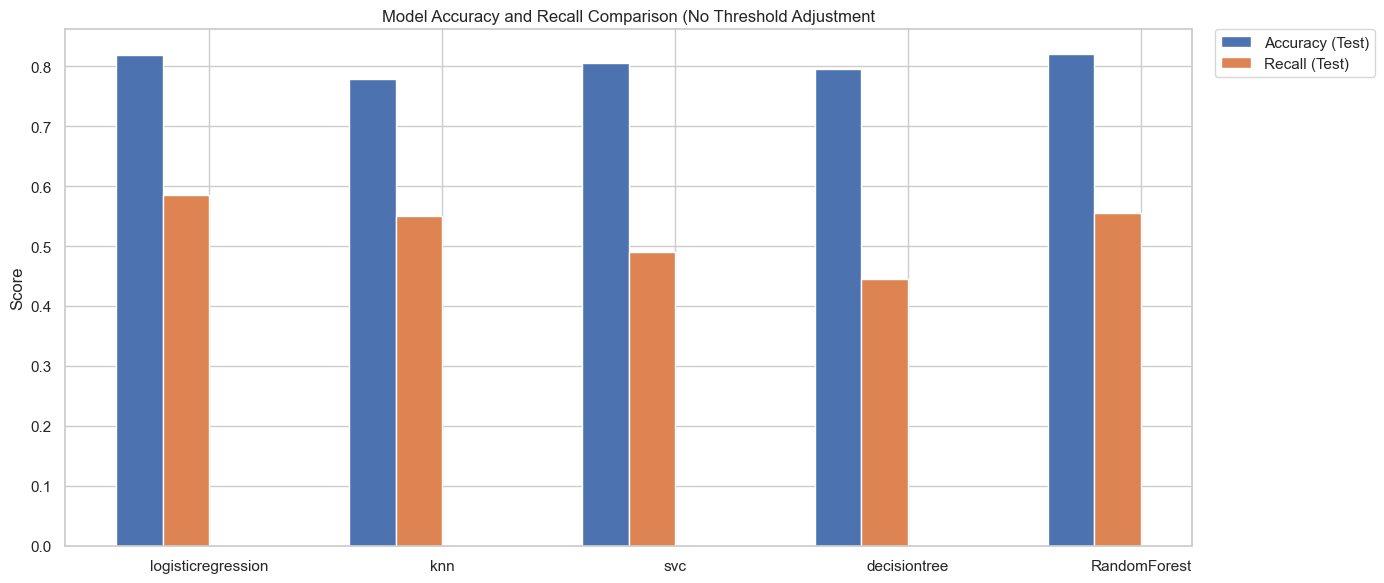

In [27]:
## plot the results for No Threshold Adjustment.

# Set plot style
sns.set(style="whitegrid")

# 1. Plot accuracy and recall scores for each model
x_labels = results_df.index.tolist()
n_models = len(x_labels)
group_spacing = 0.2  # space between model groups
bar_width = 0.2

# Create positions for each model group
x = np.arange(n_models) * (4 * bar_width + group_spacing)

# Plot
plt.figure(figsize=(14, 6))
plt.bar(x, results_df['test score'], width=bar_width, label='Accuracy (Test)')
plt.bar(x + bar_width, results_df['test recall'], width=bar_width, label='Recall (Test)')

# Set x-ticks
plt.xticks(x + 1.5 * bar_width, x_labels, rotation=0)
plt.ylabel('Score')
plt.title('Model Accuracy and Recall Comparison (No Threshold Adjustment')
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.tight_layout()
plt.show()

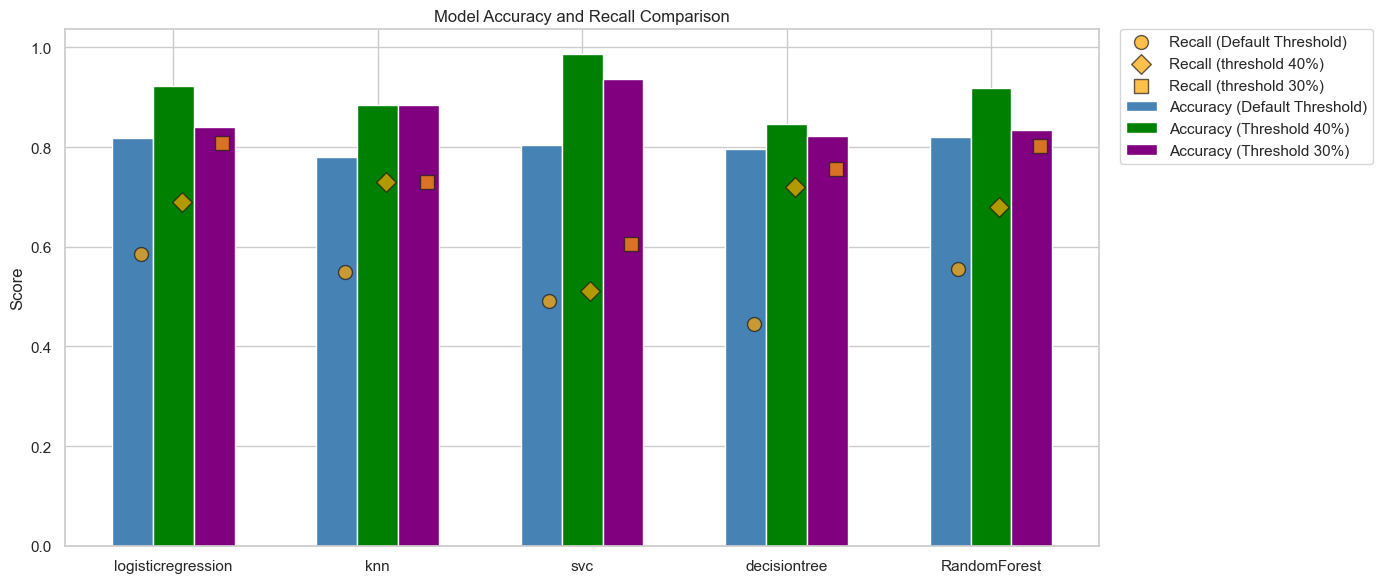

In [28]:
plt.figure(figsize=(14, 6))

x = np.arange(len(results_df.index))
width = 0.2  # smaller width for bars to add spacing

# Accuracy bars
plt.bar(x - width, results_df['test score'], width=width, label='Accuracy (Default Threshold)', color='steelblue')
plt.bar(x, results_df['test score thr40%'], width=width, label='Accuracy (Threshold 40%)', color='green')
plt.bar(x + width, results_df['test score thr30%'], width=width, label='Accuracy (Threshold 30%)', color='purple')

# Recall as scatter points (cloud style) with some jitter horizontally
jitter = 0.04
plt.scatter(x - width + jitter, results_df['test recall'], label='Recall (Default Threshold)', color='orange', s=100, alpha=0.7, marker='o', edgecolors='k')
plt.scatter(x + jitter, results_df['test recall thr40%'], label='Recall (threshold 40%)', color='orange', s=100, alpha=0.7, marker='D', edgecolors='k')
plt.scatter(x + width + jitter, results_df['test recall thr30%'], label='Recall (threshold 30%)', color='orange', s=100, alpha=0.7, marker='s', edgecolors='k')

# Set x-ticks with space between model groups
plt.xticks(x, results_df.index, rotation=0)

plt.ylabel('Score')
plt.title('Model Accuracy and Recall Comparison')
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.tight_layout()
plt.show()

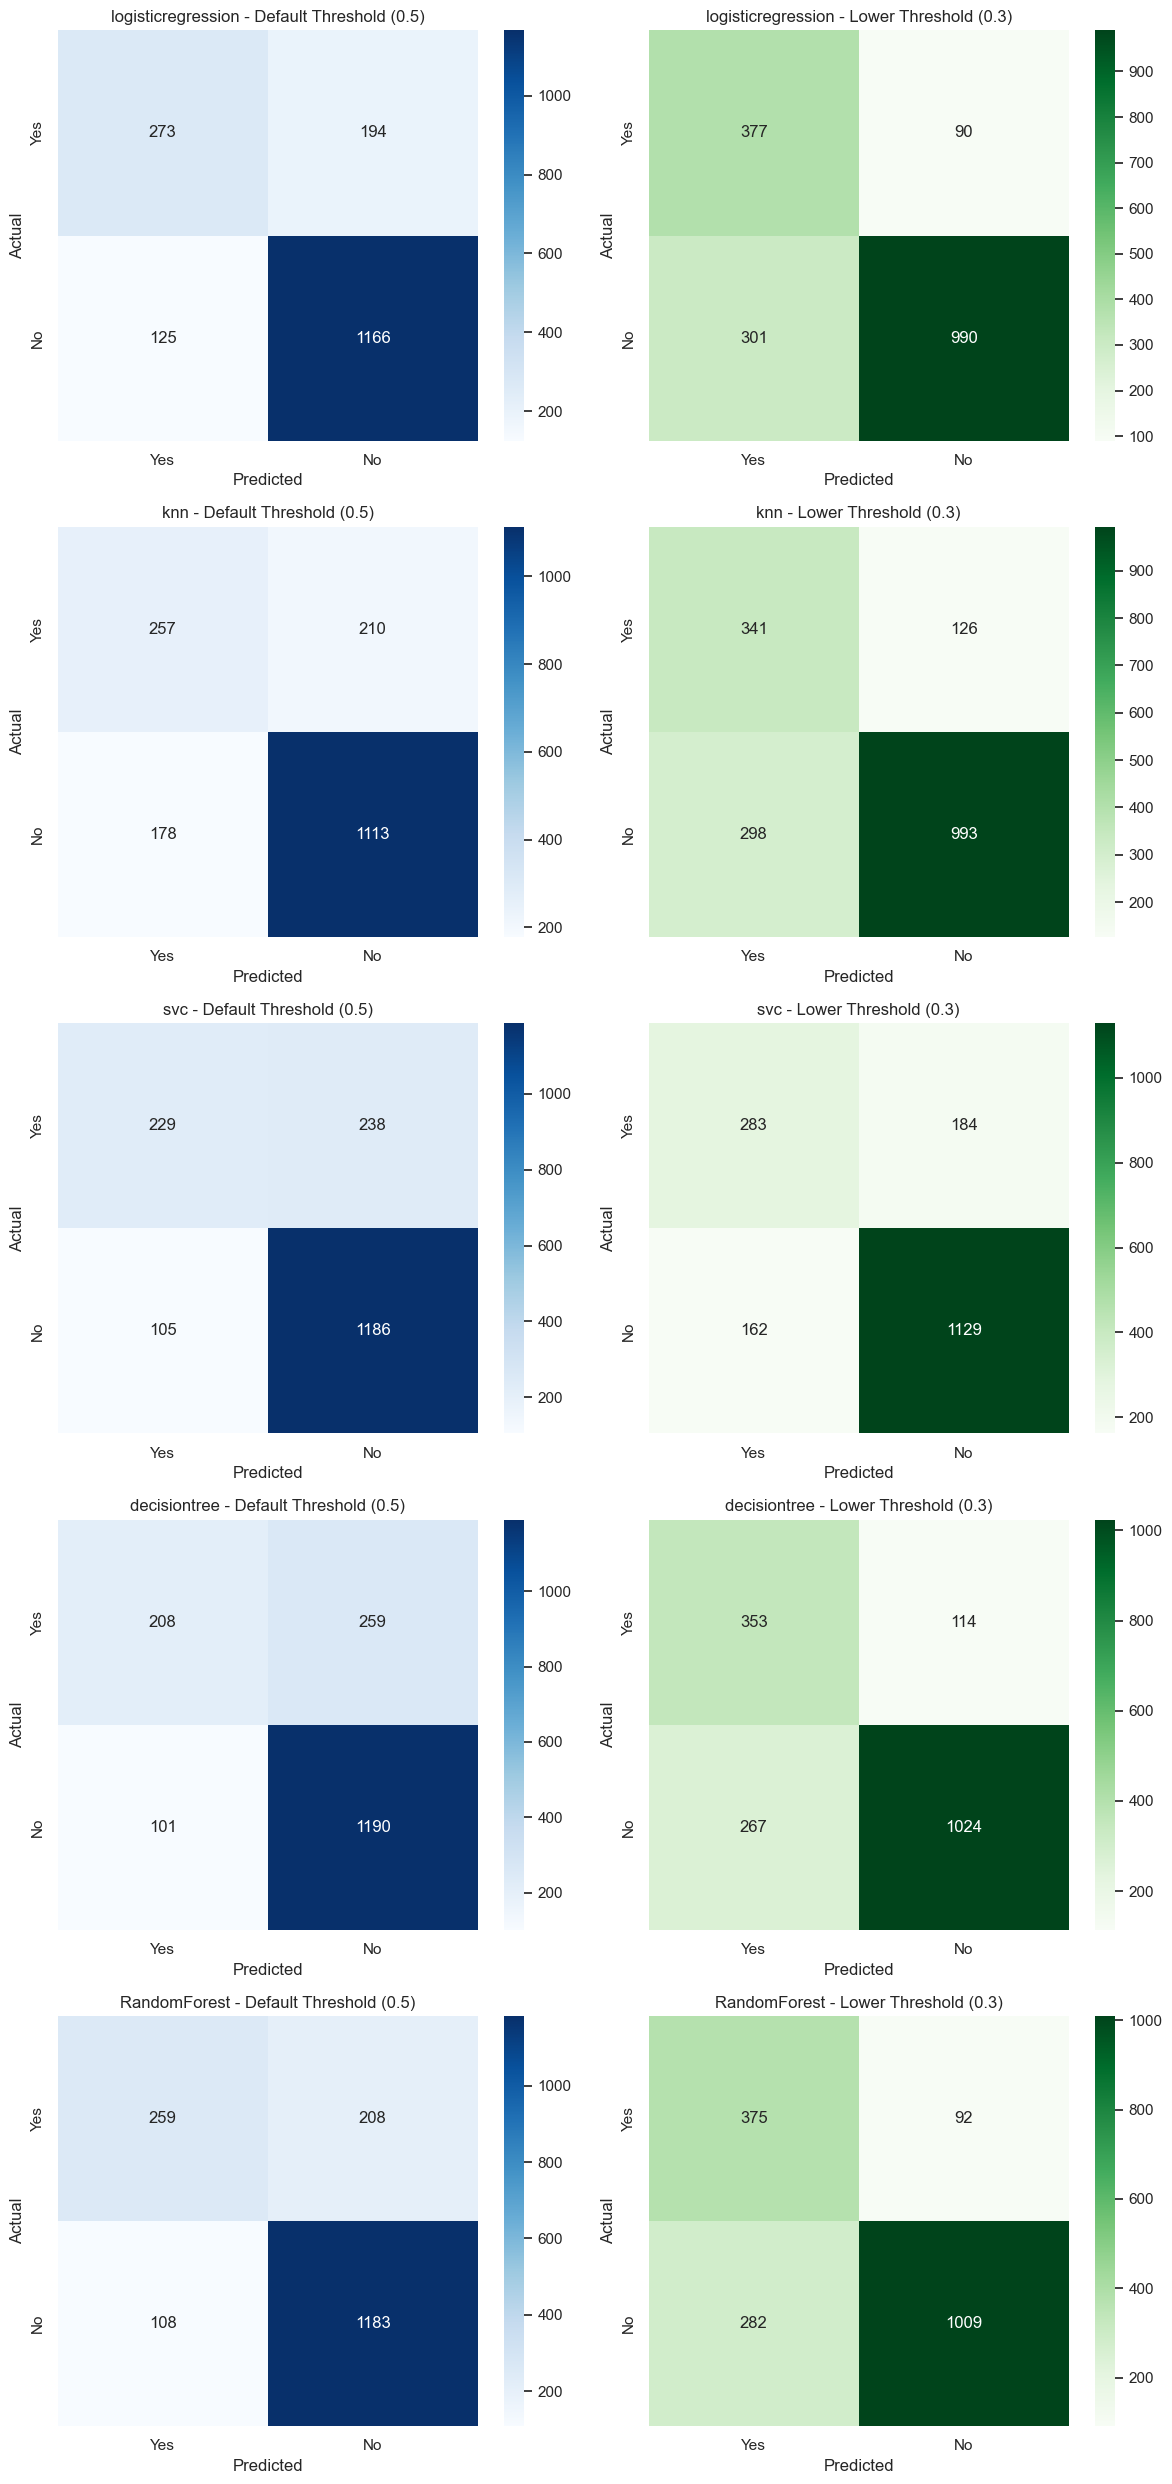

In [29]:
# 2. Plot confusion matrices for each model
fig, axes = plt.subplots(nrows=len(best_models), ncols=2, figsize=(12, 5 * len(best_models)))

for i, (name, model) in enumerate(best_models.items()):
    # Default predictions (threshold 0.5)
    y_pred = model.predict(X_test)

    # Predictions with lowered threshold (0.3)
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred_proba = np.where(y_proba > 0.3, 'Yes', 'No')

    # Compute confusion matrices
    cm_default = confusion_matrix(y_test, y_pred, labels=['Yes', 'No'])
    cm_lower = confusion_matrix(y_test, y_pred_proba, labels=['Yes', 'No'])

    # Plot confusion matrix for default threshold
    sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues', ax=axes[i, 0],
                xticklabels=['Yes', 'No'], yticklabels=['Yes', 'No'])
    axes[i, 0].set_title(f'{name} - Default Threshold (0.5)')
    axes[i, 0].set_xlabel('Predicted')
    axes[i, 0].set_ylabel('Actual')

    # Plot confusion matrix for lower threshold
    sns.heatmap(cm_lower, annot=True, fmt='d', cmap='Greens', ax=axes[i, 1],
                xticklabels=['Yes', 'No'], yticklabels=['Yes', 'No'])
    axes[i, 1].set_title(f'{name} - Lower Threshold (0.3)')
    axes[i, 1].set_xlabel('Predicted')
    axes[i, 1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

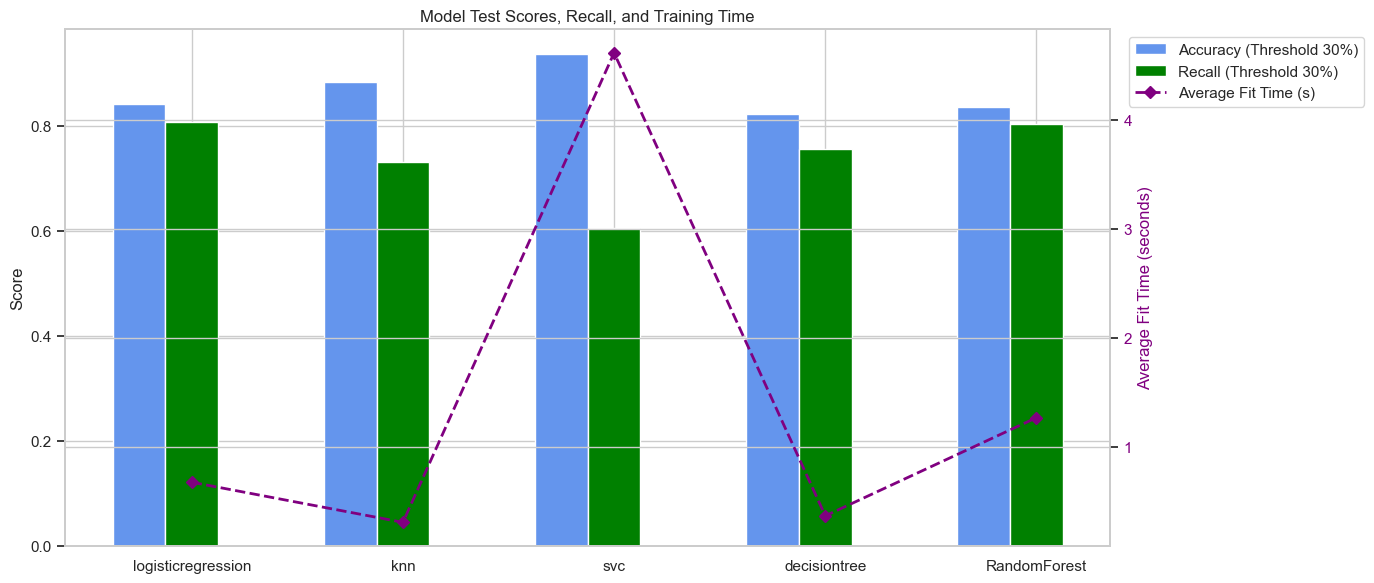

In [30]:
# PLOT the model accuracy and recal VS computation time

fig, ax1 = plt.subplots(figsize=(14, 6))
x = np.arange(len(results_df))
width = 0.25

# Plot bars for test scores and recall on primary y-axis
ax1.bar(x - width, results_df['test score thr30%'], width=width, label='Accuracy (Threshold 30%)', color='cornflowerblue')
ax1.bar(x, results_df['test recall thr30%'], width=width, label='Recall (Threshold 30%)', color='green')

# Set x-ticks
ax1.set_xticks(x, results_df.index, rotation=0)
ax1.set_ylabel('Score')
ax1.set_title('Model Test Scores, Recall, and Training Time')

# Secondary y-axis for average fit time
ax2 = ax1.twinx()
ax2.plot(x, results_df['average fit time'], label='Average Fit Time (s)', color='purple', marker='D', linewidth=2, linestyle='--')
ax2.set_ylabel('Average Fit Time (seconds)', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

# Combine legends
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper right', bbox_to_anchor=(1.25, 1.0))

plt.tight_layout()
plt.show()

## Predict Modeling findings
- the entire churn data sets are split to train data and test data.
- 5 models including logistic regression, knn, svc, decision tree, and random forest are trained based on the train data, and then to predict results for testing data. Combinations of parameters are searched for the best model parameters, by the tool, GridSearchCV. Model precition accuracy and recall scores are compared.
- It is noted that even with optimized model parameters, there is no significant improvement from the baseline model. For example, the model accuracy is about 80%, and the recall scores range from 44% to 58%. Since the company want to keep as many customers as possible, a recall score higher than 75% is desired.
- Because the 5 models with optimized parameters trained with this small data set cannog give required recall score, lower thresholds for churn is used. By default, when the probabilities is higher than 50%, the churn score is considered as "YES". I lowered probabilities to 30% or 40% .
- Both lower thresholds give better accuracy and recall scores. While 40% threshold give best accuracy, the 30% threshold gives the highest recall score, which is desired. So it is recommended to use 30% threshold for future model prediction.
- Both logistic regression and random forest give the highes recall score (around 80%), while svc model gives the highest accuracy (98% for 40% threshold). Since high recall score is our goal, logistic regression and random forest are chosen for future model prediction.
- The svc model takes significantly longer computation time than the other 4 models. The logistic regression and random forest give desired recall score, but the logistic regression model take even less time thanm the random forest model. 


## Next steps and recommendations

- The logistic regression model is recommended for the churn score prediction, based on its high recall score, and less computation time.
- The optimized model parameters for logistic regress model is {'logisticregression__C': 1}.
- Lower threshold (30% probably to be consider churn='YES') is recommended.
- Next step is to try the model with large data set, and also more features. It is expected the model accuracy and recall scores will be better.